In [134]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

In [27]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [28]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [29]:
cleaned_data.shape

(364171, 12)

In [39]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [203]:
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [206]:
# To randomly sample 100k points from both class

data_pos = cleaned_data[cleaned_data["Score"] == "positive"].sample(n = 50000)
data_neg = cleaned_data[cleaned_data["Score"] == "negative"].sample(n = 50000)
final_100k = pd.concat([data_pos, data_neg])
final_100k.shape

(100000, 12)

In [209]:
# Sort data based on time
final_100k["Time"] = pd.to_datetime(final_100k["Time"], unit = "s")
final_100k = final_100k.sort_values(by = "Time")
final_100k.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
245,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
249,346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,positive,2000-08-15,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",b'great film dont even know sum first complet ...
425,417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,negative,2001-06-11,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,b'michael keaton bring distinguish characteris...
855,138020,149792,B00004S1C6,A3B5QJVM1TLYJG,Dan Crevier,11,12,positive,2001-10-23,"Nice, bright colors!",I bought these to decorate some dia de los mue...,b'bought decor dia los muerto skull ice ateco ...


<h1>Bag of Word</h1>

In [359]:
# Fuction to compute alpha value
def naive_bayes(X_train, y_train):
    
    alpha_values = np.arange(1, 500, 0.5)
        

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    #for xy in zip(alpha_values, np.round(MSE,3)):
        #plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    return optimal_alpha

In [360]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [361]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [362]:
# split data into train and test where 70% data used to train model and 30% for test
# final_4000[:int(len(final_4000) * 0.75)], final_4000[int(len(final_4000) * 0.75):]
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(70000,) (70000,) (30000,)


In [363]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<70000x32586 sparse matrix of type '<class 'numpy.int64'>'
	with 2255040 stored elements in Compressed Sparse Row format>

In [364]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [365]:
x_test.shape

(30000, 32586)


The optimal number of alpha is 9.


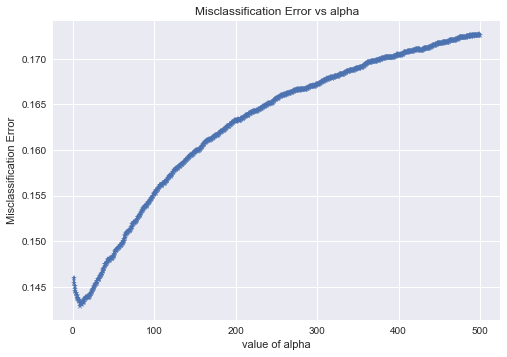

9.0

In [366]:
# To choose optimal_alpha using cross validation

optimal_alpha_bow = naive_bayes(X_train, y_train)
optimal_alpha_bow

In [367]:
# instantiate learning model alpha = optimal_alpha
nb_optimal =  MultinomialNB(alpha = optimal_alpha_bow)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = nb_optimal.predict(x_test)

In [368]:
# To get all the features name 

bow_features = bow.get_feature_names()

In [369]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 32586)

In [370]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([ 34951.,  35049.])

In [371]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-12.1691833 , -12.06382279, -12.1691833 , ..., -12.1691833 ,
        -12.06382279, -12.1691833 ],
       [-11.8136527 , -11.99597426, -11.99597426, ..., -11.99597426,
        -12.10133478, -11.99597426]])

In [372]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(32586, 2)

In [373]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -4.406540
like      -4.474184
product   -4.613860
one       -4.922815
flavor    -4.976249
tri       -5.074395
would     -5.076610
use       -5.221994
good      -5.237169
coffe     -5.258876
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -4.613539
tast      -4.697935
good      -4.829631
flavor    -4.866356
love      -4.879093
great     -4.912503
use       -4.928399
one       -4.996004
product   -5.034110
tri       -5.078764
Name: 1, dtype: float64


In [374]:
# Accuracy on train data
train_acc_bow = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.868614285714


In [375]:
# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.131386%


In [376]:
# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_bow, acc_bow))


The accuracy of the naive bayes classifier for alpha = 9 is 85.746667%


In [377]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[12871,  2178],
       [ 2098, 12853]])

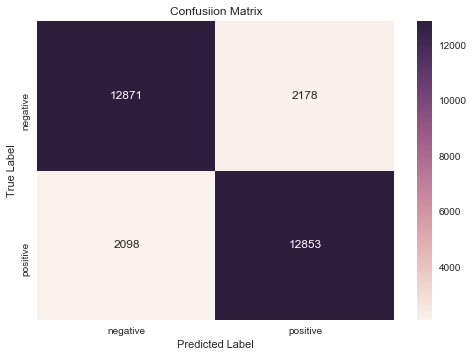

In [378]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [379]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.86      0.86      0.86     15049
   positive       0.86      0.86      0.86     14951

avg / total       0.86      0.86      0.86     30000



**Terminology**<br>

**true positives (TP):** We predicted +ve review, and review is also +ve.<br>
**true negatives (TN):** We predicted -ve, and review is also -ve.<br>
**false positives (FP):** We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.")<br>
**false negatives (FN):** We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")<br>


**confusion matrix described**<br>
In above confusion matrix(used to describe performence of classifier)

1. tn(true negative) = 12871, tp(true positive) = 12853, fn(false negative) = 2098, fp(false positive) = 2178
2. And as it is shows in classification report overall accuracy(i.e. how often is the classifier correct?) = (tp+tn)/total = (12853+12871)/30000 = ~86%
3. And Overall error rate/misclassification rate or 1-accuracy(i.e. how often it is wrong?) --> (fn+fp)/total = (2098+2178)/30000 = ~14%
4. precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 12853/15031 = ~86%
5. True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 12853/14951 = ~86%
6. Specificity(True Negative Rate)--> When it's actually -ve, how often does it predict -ve? = tn/actual negative = 12871/15049 = ~86%. The best specificity is 1.0, whereas the worst is 0.0 .
7. False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 2098/15049 = ~14%
8. F1 score/F-score/F-measure is weighted avg of precision and recall(tpr).
9. support is number of elements in each class(+ve and -ve).

**Observations**</br>
1. From above figure(misclassification error vs optimal alpha) It is showing that classification error for each value of alpha, when alpha is increaseing the error is also increasing. 
2. As I tested our model on unseen data(test data) the accuracy is 86% when alpha = 9.0
3. In confusion matrix, It is clear that out of 30k unseen data-points classifier predict 12853 +ve and 12871 -ve class label but in real 15049 were +ve and 14951 were -ve.
4. In a nutshell we can say the generalization error is low means this model works well with unseen data.

<h1>Tf-Idf</h1>

In [380]:
# data
X = final_100k["CleanedText"]

In [381]:
# Target/class-label
y = final_100k["Score"]

In [382]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [383]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<70000x1028229 sparse matrix of type '<class 'numpy.float64'>'
	with 4889381 stored elements in Compressed Sparse Row format>

In [384]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(30000, 1028229)


The optimal number of alpha is 1.


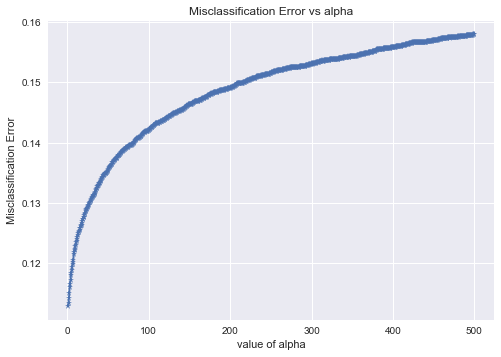

1.0

In [385]:
# To choosing optimal_alpha

optimal_alpha_tfidf = naive_bayes(X_train, y_train)
optimal_alpha_tfidf

In [386]:
# instantiate learning model alpha = optimal_alpha
nb_optimal = MultinomialNB(alpha = optimal_alpha_tfidf)

# fitting the model
nb_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = nb_optimal.predict(x_test)

In [387]:
# To get all the features name 

tfidf_features = tf_idf_vect.get_feature_names()

In [389]:
# To count feature for each class while fitting the model
# Number of samples encountered for each (class, feature) during fitting

feat_count = nb_optimal.feature_count_
feat_count.shape

(2, 1028229)

In [390]:
# Number of samples encountered for each class during fitting

nb_optimal.class_count_

array([ 34951.,  35049.])

In [391]:
# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob = nb_optimal.feature_log_prob_
log_prob

array([[-14.06546285, -14.06546285, -14.06546285, ..., -13.99001422,
        -14.06546285, -14.06546285],
       [-13.77976545, -13.95859125, -13.97356346, ..., -14.0581703 ,
        -13.92181468, -13.92181468]])

In [392]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(1028229, 2)

In [393]:
# To show top 10 feature from both class
print("Top 10 negative features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 positive features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 negative features:-
 tast      -7.588491
like      -7.718632
product   -7.757981
flavor    -8.041283
coffe     -8.045851
one       -8.083109
would     -8.098194
tri       -8.183709
buy       -8.223379
order     -8.242279
Name: 0, dtype: float64


 Top 10 positive features:-
 great     -7.722694
love      -7.747420
good      -7.858000
tea       -7.915250
like      -7.915798
tast      -7.922311
flavor    -7.943132
coffe     -7.956116
use       -8.030975
product   -8.110466
Name: 1, dtype: float64


In [394]:
# Accuracy on train data
train_acc_tfidf = nb_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 0.967528571429


In [395]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.032471%


In [396]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha_tfidf, acc_tfidf))


The accuracy of the naive bayes classifier for alpha = 1 is 88.556667%


In [397]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[13300,  1749],
       [ 1684, 13267]])

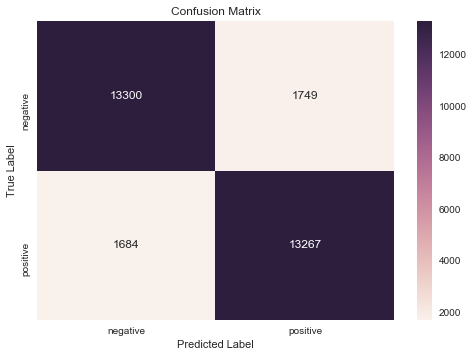

In [398]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [399]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.89      0.88      0.89     15049
   positive       0.88      0.89      0.89     14951

avg / total       0.89      0.89      0.89     30000



**Observations**
1. look at the bow observations for clarifying doubt.
2. As in "naive baiyes with tfidf" when alpha = 9.0 the accuracy is quite good than bow. In this model, train_error and test_error is low.
3. In a nutshell we can say this model works well with unseen data and also have high accuracy than bow representation.
4. After printing top feature from both class we found that features are not in 

**Conclusions**
1. Naive bayes are good at text classification task like spam filtering, sentimental analysis, RS etc. 
2. As we know when a model performs good on training data but poor performence on unseen data(test data)i.e. its dependent on training data only, tends to overfits and when a model perform poor performence on training data and good performence on test data i.e. it fails to learn relationship in training data tends to underfit. We need to balance between both i.e. reduce training error and balance error between both training and testing which is balanced in this case.
3. Another concept bias vs variance is also related with underfitting and overfitting. when a model has high bias and low variance tend to underfitting and its reverse- high variance and low bias called overfitting and we balanced using cross-validataion. As it is shown in below table where both models have low trainig error and test error.
4. overall, both of the models are performing well on unseen data.
5. As we are not applying naive bayes on word2vec representation because it sometimes gives -ve value(i.e. if two word have 0 cosine similarity the word is completly orthogonal i.e. they are not related with each other. and 1 represents perfect relationship between word vector. whereas -ve similarity means they are perfect opposite relationship between word) and we know naive bayes assume that presence of a particular feature in a class is unrelated to presence of any other feature, which is most unlikely in real word. Although, it works well.
6. And from point # 5, features are dependent or there are relationship between features. So applying naive bayes on dependent feature does not make any sense.

In [402]:
# model performence table
models = pd.DataFrame({'Model': ['Naive Bayes with Bow', "Naive Bayes with TFIDF"], 'Hyper Parameter(alpha)': [optimal_alpha_bow, optimal_alpha_tfidf], 'Train Error': [train_err_bow, train_err_tfidf], 'Test Error': [100-acc_bow, 100-acc_tfidf], 'Accuracy': [acc_bow, acc_tfidf]}, columns = ["Model", "Hyper Parameter(alpha)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(alpha),Train Error,Test Error,Accuracy
1,Naive Bayes with TFIDF,1.0,0.032471,11.443333,88.556667
0,Naive Bayes with Bow,9.0,0.131386,14.253333,85.746667
